<a href="https://colab.research.google.com/github/ashikshafi08/Learning-Fastai/blob/main/Part_2/Stable_Diffusion_Deep_Dive.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Making the necessary imports needed

In [ ]:
!pip install -q --upgrade transformers diffusers ftfy


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 47.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 737.4/737.4 kB 34.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.1/53.1 kB 3.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 64.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.1/200.1 kB 15.8 MB/s eta 0:00:00


In [ ]:
from base64 import b64encode

import numpy
import torch
from diffusers import AutoencoderKL, LMSDiscreteScheduler, UNet2DConditionModel
from huggingface_hub import notebook_login

# For video display:
from IPython.display import HTML
from matplotlib import pyplot as plt
from pathlib import Path
from PIL import Image
from torch import autocast
from torchvision import transforms as tfms
from tqdm.auto import tqdm
from transformers import CLIPTextModel, CLIPTokenizer, logging

torch.manual_seed(1)
if not (Path.home()/'.huggingface'/'token').exists(): notebook_login()

# Supress some unnecessary warnings when loading the CLIPTextModel
logging.set_verbosity_error()

# Set device
torch_device = "cuda" if torch.cuda.is_available() else "cpu"

Token is valid.
Your token has been saved in your configured git credential helpers (store).
Your token has been saved to /root/.cache/huggingface/token
Login successful


### Loading the models 

The below code will download and setup the relevant models and components we'll be needing. 

In [ ]:
# Putting all these models to train and work in the GPU
# Loading the auotencoder model which will be used to decode the latents into image space (Feature vec for image)
vae = AutoencoderKL.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="vae").to(torch_device) # subfolder vae 

# Load the tokenizer for the texts and the respective encoder 
tokenizer = CLIPTokenizer.from_pretrained("openai/clip-vit-large-patch14")
text_encoder = CLIPTextModel.from_pretrained("openai/clip-vit-large-patch14").to(torch_device)

# The Unet model we've discussed in prev lecture is been loaded here 
unet = UNet2DConditionModel.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder = "unet").to(torch_device)

# The noise scheduler to pick up the noise for each images
scheduler = LMSDiscreteScheduler(beta_start = 0.00085 , beta_end = 0.012 , 
                                 beta_schedule = "scaled_linear" , num_train_timesteps = 1000)




Cannot initialize model with low cpu memory usage because `accelerate` was not found in the environment. Defaulting to `low_cpu_mem_usage=False`. It is strongly recommended to install `accelerate` for faster and less memory-intense model loading. You can do so with: 
```
pip install accelerate
```
.


Cannot initialize model with low cpu memory usage because `accelerate` was not found in the environment. Defaulting to `low_cpu_mem_usage=False`. It is strongly recommended to install `accelerate` for faster and less memory-intense model loading. You can do so with: 
```
pip install accelerate
```
.


### Diffusion Loop 

This is the loop which is adapted from the HF Noteboo and its from the `__call__` method of the stable diffusion pipeline. 

https://github.com/huggingface/diffusers/blob/main/src/diffusers/pipelines/stable_diffusion/pipeline_stable_diffusion.py#L200

For now we'll just copy paste the code and in letter section we will dig deep and unravel each component of the loop and put it together.

0it [00:00, ?it/s]

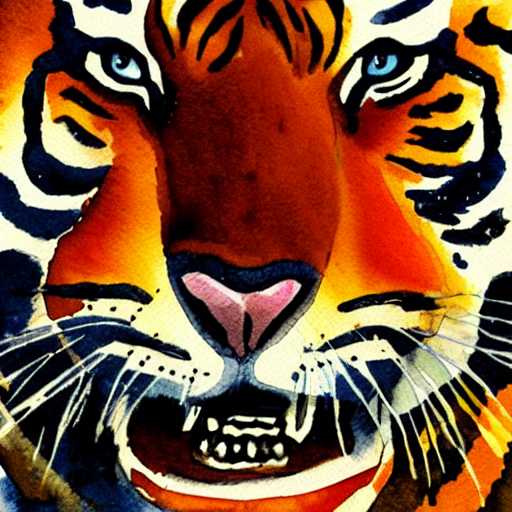

In [ ]:
# Some settings
prompt = ["A watercolor painting of an very angry tiger"]
height = 512                        # default height of Stable Diffusion
width = 512                         # default width of Stable Diffusion
num_inference_steps = 30            # Number of denoising steps
guidance_scale = 7.5                # Scale for classifier-free guidance
generator = torch.manual_seed(32)   # Seed generator to create the inital latent noise
batch_size = 1

# Prep text 
text_input = tokenizer(prompt, padding="max_length", max_length=tokenizer.model_max_length, truncation=True, return_tensors="pt")
with torch.no_grad():
    text_embeddings = text_encoder(text_input.input_ids.to(torch_device))[0]
max_length = text_input.input_ids.shape[-1]
uncond_input = tokenizer(
    [""] * batch_size, padding="max_length", max_length=max_length, return_tensors="pt"
)
with torch.no_grad():
    uncond_embeddings = text_encoder(uncond_input.input_ids.to(torch_device))[0] 
text_embeddings = torch.cat([uncond_embeddings, text_embeddings])

# Prep Scheduler
scheduler.set_timesteps(num_inference_steps)

# Prep latents
latents = torch.randn(
  (batch_size, unet.in_channels, height // 8, width // 8),
  generator=generator,
)
latents = latents.to(torch_device)
latents = latents * scheduler.init_noise_sigma # Scaling (previous versions did latents = latents * self.scheduler.sigmas[0]

# Loop
with autocast("cuda"):
    for i, t in tqdm(enumerate(scheduler.timesteps)):
        # expand the latents if we are doing classifier-free guidance to avoid doing two forward passes.
        latent_model_input = torch.cat([latents] * 2)
        sigma = scheduler.sigmas[i]
        # Scale the latents (preconditioning):
        # latent_model_input = latent_model_input / ((sigma**2 + 1) ** 0.5) # Diffusers 0.3 and below
        latent_model_input = scheduler.scale_model_input(latent_model_input, t)

        # predict the noise residual
        with torch.no_grad():
            noise_pred = unet(latent_model_input, t, encoder_hidden_states=text_embeddings).sample

        # perform guidance
        noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
        noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond)

        # compute the previous noisy sample x_t -> x_t-1
        # latents = scheduler.step(noise_pred, i, latents)["prev_sample"] # Diffusers 0.3 and below
        latents = scheduler.step(noise_pred, t, latents).prev_sample

# scale and decode the image latents with vae
latents = 1 / 0.18215 * latents
with torch.no_grad():
    image = vae.decode(latents).sample

# Display
image = (image / 2 + 0.5).clamp(0, 1)
image = image.detach().cpu().permute(0, 2, 3, 1).numpy()
images = (image * 255).round().astype("uint8")
pil_images = [Image.fromarray(image) for image in images]
pil_images[0]

## The AutoEncoder (AE) 

AE can `encode` an image into some sort of latent representation and `decode` it back into an image. 

**Some Notes**
- It doesn't operate on pixels instead it operates on the latent space or other autoencoders (VAE specifically).
- The VAE is helps in compressing large number of imaages and compress them into latent.

Below is the code that will do what we've discussed above.

In [ ]:
# From image to some latent 
# We use VAE to compress the image pixels to some sort of latents 

def pil_to_latent(input_im):

  with torch.no_grad():
    # Calling the encode on th etensor version of the image
    latent = vae.encode(tfms.ToTensor()(input_im).unsqueeze(0).to(torch_device)*2-1) # 2-1 is the scaling
    # 0.18125 is the scaling factor used in the paper (author)
    # we sample from the distribution calculated
  return 0.18215 * latent.latent_dist.sample()

In [ ]:
# From latents to image 
# Decode the latents to image 

def latents_to_pil(latents):
  # batch of latent -> list of images
  latents = (1 / 0.18215) * latents # reverse latent decoding / removing the scaling 
  with torch.no_grad():
    image = vae.decode(latents).sample # sample using the distribution

  # All things below is to retain the original pil image passed in
  image = (image / 2 + 0.5).clamp(0 , 1)
  image = image.detach().cpu().permute(0 , 2, 3, 1).numpy() 
  images = (image * 255).round().astype("uint8")
  pil_images = [Image.fromarray(image) for image in images]
  return pil_images

In [ ]:
# Download a demo Image
!curl --output macaw.jpg 'https://lafeber.com/pet-birds/wp-content/uploads/2018/06/Scarlet-Macaw-2.jpg'

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 62145  100 62145    0     0   231k      0 --:--:-- --:--:-- --:--:--  231k


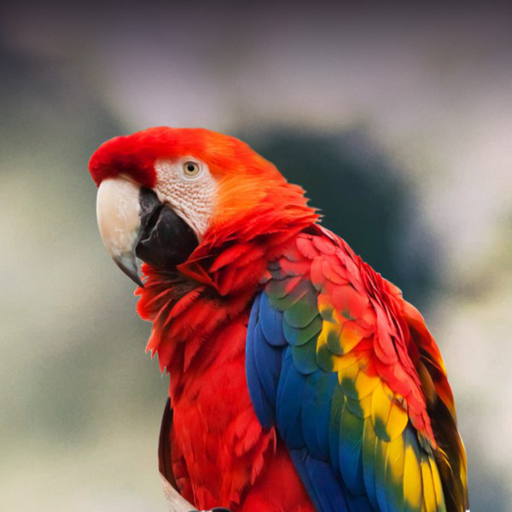

In [ ]:
#  Load the image with PIL
input_image = Image.open('macaw.jpg').resize((512, 512))
input_image

Encode the image into latent space of the autoencoder with the function we've defined. 

In [ ]:
encoded = pil_to_latent(input_image)
encoded.shape # shape of the latents

torch.Size([1, 4, 64, 64])

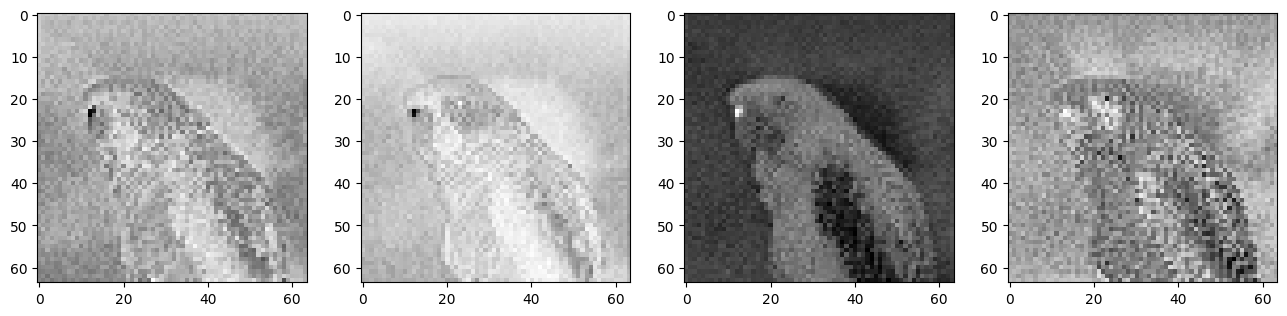

In [ ]:
# Lets visualize the four channels for our image 
fig , axs = plt.subplots(1 , 4, figsize = (16 , 4))
for c in range(4):
  axs[c].imshow(encoded[0][c].cpu() , cmap = "Greys")

When we pass this into the decoder we get back something very close to our input image.

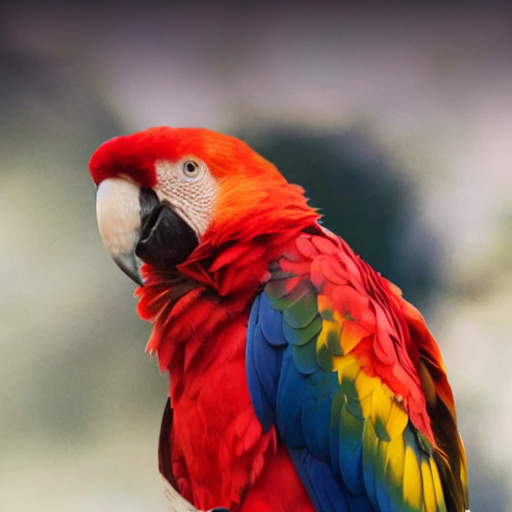

In [ ]:
# Decode this latent representation back into an image 
decoded = latents_to_pil(encoded)[0] # [0] to get the image except the object
decoded

This autoencoder has been trained to squish down an image to a smaller representation and then re-create the image back from this compressed version again.

In this particular case the compression factor is 48, we start with a 3x512x512(chxhtxwd) image and it get compressed to a latent vector 4x64x64. Each 3x8x8 pixel volume in the input image gets compressed down to just 4 numbers(4x1x1). You can find AEs with a higher compression ratio (eg f16 like some popular VQGAN models) but at some point they begin to introduce artifacts that we don't want.


**Why VAE for compression ?**


Why do we even use an autoencoder? We can do diffusion in pixel space - where the model gets all the image data as inputs and produces an output prediction of the same shape. But this means processing a LOT of data, and make high-resolution generation very computationally expensive. Some solutions to this involve doing diffusion at low resolution (64px for eg) and then training a separate model to upscale repeatedly (as with D2/Imagen). But latent diffusion instead does the diffusion process in this 'latent space', using the compressed representations from our AE rather than raw images. These representations are information rich, and can be small enough to handle manageably on consumer hardware. Once we've generated a new 'image' as a latent representation, the autoencoder can take those final latent outputs and turn them into actual pixels.




## The Scheduler 

We use this to add some noise to an image and the nhave the model try to predict the noise. 


**Why we need a scheduler** 

We can't do the random noise addition to our images. If we always added a ton of noise, the model might not have much to work with. If we only add a tiny amount, the model won't be able to do much with the random starting points we use for sampling. So during training the amount is varied, according to some distribution.


We want to denoise over a number of steps, how many steps and how much noise we should aim for at each step are going to affect the final result. 

The scheduler is in charge of handling all of these details. For example: scheduler = LMSDiscreteScheduler(beta_start=0.00085, beta_end=0.012, beta_schedule="scaled_linear", num_train_timesteps=1000) sets up a scheduler that matches the one used to train this model. When we want to sample over a smaller number of steps, we set this up with scheduler.set_timesteps:


In [ ]:
# Setting the number of sampling steps 
scheduler.set_timesteps(15)

In [ ]:
scheduler.timesteps

tensor([999.0000, 927.6429, 856.2857, 784.9286, 713.5714, 642.2143, 570.8571,
        499.5000, 428.1429, 356.7857, 285.4286, 214.0714, 142.7143,  71.3571,
          0.0000], dtype=torch.float64)

In [ ]:
# How much noise is present at each timestep? 
print(scheduler.sigmas)

tensor([14.6146,  9.6826,  6.6780,  4.7746,  3.5221,  2.6666,  2.0606,  1.6156,
         1.2768,  1.0097,  0.7913,  0.6056,  0.4397,  0.2780,  0.0292,  0.0000])


During the sampling, we will start with high noise and then gradually denoise down to an image. 

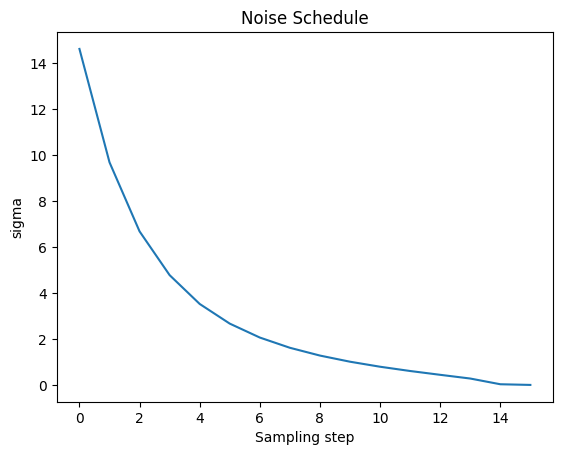

In [ ]:
# Plotting this noise schedule:
plt.plot(scheduler.sigmas)
plt.title('Noise Schedule')
plt.xlabel('Sampling step')
plt.ylabel('sigma')
plt.show()

The sigma is the amount of noise added to the latet representation. Lets visualize what this looks like by adding a bit of **noise to our encoded image and then decoding the noised version**.


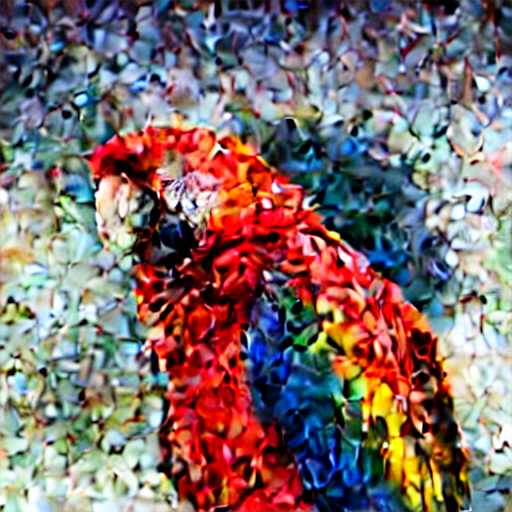

In [ ]:
# Creating some random noise (noise is same shape as the latent representation)
noise = torch.randn_like(encoded)

sampling_step = 10 # equivalent to step 10 out of 15 in the scheduler above 
# playaround with the above 

# Takes in the encoder, noise, and the timestep (t)
encoded_and_noised = scheduler.add_noise(encoded, noise, timesteps = torch.tensor([scheduler.timesteps[sampling_step]]))

# Display the image
latents_to_pil(encoded_and_noised.float())[0] 


The main implementation of the above, 

`noisy_sample = original_samples * noise * sigma`

If we want to start from random noise instead of a noised image, we need to scale it by the largest sigma value used during training, ~14 in this case. And before these noisy latents are fed to the model they are scaled again in the so-called pre-conditioning step: `latent_model_input = latent_model_input / ((sigma**2 + 1) ** 0.5)` (now handled by `latent_model_input = scheduler.scale_model_input(latent_model_input, t))`. 

### Running a example loop 

Lets use image as a starting point by adding some noise and doing the final denoising steps in the loop with a new prompt. 


0it [00:00, ?it/s]

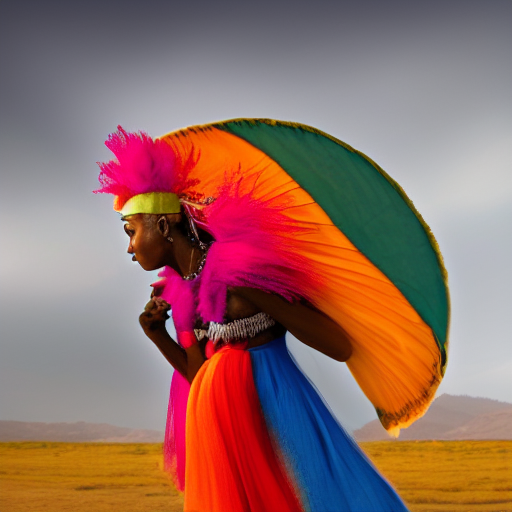

In [ ]:
# Settings (same as before except for the new prompt)
prompt = ["A colorful dancer, nat geo photo"]
height = 512                        # default height of Stable Diffusion
width = 512                         # default width of Stable Diffusion
num_inference_steps = 50            # Number of denoising steps
guidance_scale = 8                  # Scale for classifier-free guidance
generator = torch.manual_seed(32)   # Seed generator to create the inital latent noise
batch_size = 1

# Prep text (same as before)
text_input = tokenizer(prompt, padding="max_length", max_length=tokenizer.model_max_length, truncation=True, return_tensors="pt")
with torch.no_grad():
    text_embeddings = text_encoder(text_input.input_ids.to(torch_device))[0]
max_length = text_input.input_ids.shape[-1]
uncond_input = tokenizer(
    [""] * batch_size, padding="max_length", max_length=max_length, return_tensors="pt"
)
with torch.no_grad():
    uncond_embeddings = text_encoder(uncond_input.input_ids.to(torch_device))[0] 
text_embeddings = torch.cat([uncond_embeddings, text_embeddings])

# Prep Scheduler (setting the number of inference steps)
scheduler.set_timesteps(num_inference_steps)

# Prep latents (noising appropriately for start_step)
start_step = 10
start_sigma = scheduler.sigmas[start_step]
noise = torch.randn_like(encoded)
latents = scheduler.add_noise(encoded, noise, timesteps=torch.tensor([scheduler.timesteps[start_step]]))
latents = latents.to(torch_device).float()

# Loop
for i, t in tqdm(enumerate(scheduler.timesteps)):
    if i >= start_step: # << This is the only modification to the loop we do
        
        # expand the latents if we are doing classifier-free guidance to avoid doing two forward passes.
        latent_model_input = torch.cat([latents] * 2)
        sigma = scheduler.sigmas[i]
        latent_model_input = scheduler.scale_model_input(latent_model_input, t)

        # predict the noise residual
        with torch.no_grad():
            noise_pred = unet(latent_model_input, t, encoder_hidden_states=text_embeddings)["sample"]

        # perform guidance
        noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
        noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond)

        # compute the previous noisy sample x_t -> x_t-1
        latents = scheduler.step(noise_pred, t, latents).prev_sample

latents_to_pil(latents)[0]

The above is the img2img pipeline, but we need to look into how we add the text embedding pipeline too. 

## Exploring the text -> text embedding pipeline 

We use a text encoder model to turn out text into a set of "embeddings" which are fed into  the diffusion model as conditioning. 

In [ ]:
# Our example text prompt 
prompt = "A picture of a puppy"


First lets begin with tokenization 

In [ ]:
# Turn the tetx into a sequence of discrete tokens 
text_input = tokenizer(prompt , padding = "max_length" , max_length = tokenizer.model_max_length , truncation = True , 
                       return_tensors = "pt")
text_input['input_ids'][0]

tensor([49406,   320,  1674,   539,   320,  6829, 49407, 49407, 49407, 49407,
        49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407,
        49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407,
        49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407,
        49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407,
        49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407,
        49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407,
        49407, 49407, 49407, 49407, 49407, 49407, 49407])

In [ ]:
# See the individual tokens
for t in text_input['input_ids'][0][:8]:
  print(t , tokenizer.decoder.get(int(t)))

tensor(49406) <|startoftext|>
tensor(320) a</w>
tensor(1674) picture</w>
tensor(539) of</w>
tensor(320) a</w>
tensor(6829) puppy</w>
tensor(49407) <|endoftext|>
tensor(49407) <|endoftext|>


After the sentence ends, its all `<end of text>` tokens

In [ ]:
# Lets get the output embeddings when we pass our tokens into the Encoder 
output_embeddings = text_encoder(text_input['input_ids'].to(torch_device))[0]
print(f"Shape of the output embeddings : {output_embeddings.shape} \n")
output_embeddings

Shape of the output embeddings : torch.Size([1, 77, 768]) 



tensor([[[-0.3884,  0.0229, -0.0522,  ..., -0.4899, -0.3066,  0.0675],
         [ 0.0290, -1.3258,  0.3085,  ..., -0.5257,  0.9768,  0.6652],
         [ 0.6942,  0.3538,  1.0991,  ..., -1.5716, -1.2643, -0.0121],
         ...,
         [-0.0221, -0.0053, -0.0089,  ..., -0.7303, -1.3830, -0.3011],
         [-0.0062, -0.0246,  0.0065,  ..., -0.7326, -1.3745, -0.2953],
         [-0.0536,  0.0269,  0.0444,  ..., -0.7159, -1.3634, -0.3075]]],
       device='cuda:0', grad_fn=<NativeLayerNormBackward0>)

**How are these numbers for the embeddings are generated?**

The tokens are transformed into a set of input embeddings, which are then fed through the transformer model to get the final output embeddings. 

To get these input embeddings, they are actually two steps - 
`text_encoder.text_model.embeddings` if we print this out, 




In [ ]:
text_encoder.text_model.embeddings

CLIPTextEmbeddings(
  (token_embedding): Embedding(49408, 768)
  (position_embedding): Embedding(77, 768)
)

Token embeddings takes the tokens and map it into reprsentation of numericals. They will be learned embeddings. 

In [ ]:
# Accessing the embedding layer 
token_emb_layer = text_encoder.text_model.embeddings.token_embedding

# Vocab size 49408 , embed_dim 768 
token_emb_layer 

Embedding(49408, 768)

In [ ]:
# Embed a token, for the word puppy

embedding = token_emb_layer(torch.tensor(6829 , device = torch_device))
embedding.shape

torch.Size([768])

In [ ]:
# Now for all the tokens 
token_embeddings = token_emb_layer(text_input.input_ids.to(torch_device))
print(token_embeddings.shape) # batch size 1, 77 tokens in total, 768 values for each token
token_embeddings

torch.Size([1, 77, 768])


tensor([[[ 0.0011,  0.0032,  0.0003,  ..., -0.0018,  0.0003,  0.0019],
         [ 0.0013, -0.0011, -0.0126,  ..., -0.0124,  0.0120,  0.0080],
         [ 0.0235, -0.0118,  0.0110,  ...,  0.0049,  0.0078,  0.0160],
         ...,
         [ 0.0012,  0.0077, -0.0011,  ..., -0.0015,  0.0009,  0.0052],
         [ 0.0012,  0.0077, -0.0011,  ..., -0.0015,  0.0009,  0.0052],
         [ 0.0012,  0.0077, -0.0011,  ..., -0.0015,  0.0009,  0.0052]]],
       device='cuda:0', grad_fn=<EmbeddingBackward0>)

### Positional embeddings 

Positional embeddings tell the mdoel where in a sequence a token is present. These are optionally learnable parameters. 

So each token has its own embedding.

In [ ]:
pos_emb_layer = text_encoder.text_model.embeddings.position_embedding 
pos_emb_layer

Embedding(77, 768)

In [ ]:
# Positional embedding for each position 
position_ids = text_encoder.text_model.embeddings.position_ids[: , :77]
positional_embeddings = pos_emb_layer(position_ids)
print(positional_embeddings.shape)
positional_embeddings

torch.Size([1, 77, 768])


tensor([[[ 0.0016,  0.0020,  0.0002,  ..., -0.0013,  0.0008,  0.0015],
         [ 0.0042,  0.0029,  0.0002,  ...,  0.0010,  0.0015, -0.0012],
         [ 0.0018,  0.0007, -0.0012,  ..., -0.0029, -0.0009,  0.0026],
         ...,
         [ 0.0216,  0.0055, -0.0101,  ..., -0.0065, -0.0029,  0.0037],
         [ 0.0188,  0.0073, -0.0077,  ..., -0.0025, -0.0009,  0.0057],
         [ 0.0330,  0.0281,  0.0289,  ...,  0.0160,  0.0102, -0.0310]]],
       device='cuda:0', grad_fn=<EmbeddingBackward0>)

In [ ]:
example_pos = text_encoder.text_model.embeddings.position_ids

In [ ]:
example_pos.shape

torch.Size([1, 77])

In [ ]:
# Both token and positional are of same shape, so easy to add them 
pos_emb_layer(example_pos[: , :77]).shape , token_embeddings.shape

(torch.Size([1, 77, 768]), torch.Size([1, 77, 768]))

### Combining token and positional embeddings together 

Combining them in this way gives us the final input embeddings ready to feed through the transformer model. 

In [ ]:
input_embeddings = token_embeddings + positional_embeddings 
print(input_embeddings.shape)
input_embeddings

torch.Size([1, 77, 768])


tensor([[[ 2.6770e-03,  5.2133e-03,  4.9323e-04,  ..., -3.1321e-03,
           1.0659e-03,  3.4316e-03],
         [ 5.5371e-03,  1.7510e-03, -1.2381e-02,  ..., -1.1410e-02,
           1.3508e-02,  6.8378e-03],
         [ 2.5356e-02, -1.1019e-02,  9.7663e-03,  ...,  1.9460e-03,
           6.8375e-03,  1.8573e-02],
         ...,
         [ 2.2781e-02,  1.3262e-02, -1.1241e-02,  ..., -8.0054e-03,
          -2.0560e-03,  8.9366e-03],
         [ 2.0026e-02,  1.5015e-02, -8.7638e-03,  ..., -4.0313e-03,
           1.8487e-05,  1.0885e-02],
         [ 3.4206e-02,  3.5826e-02,  2.7768e-02,  ...,  1.4465e-02,
           1.1110e-02, -2.5745e-02]]], device='cuda:0', grad_fn=<AddBackward0>)

The input embeddings have some information related to the tokens and some information related to the position. 

In [ ]:
# The following combines all the above steps 

text_encoder.text_model.embeddings(text_input.input_ids.to(torch_device))

tensor([[[ 2.6770e-03,  5.2133e-03,  4.9323e-04,  ..., -3.1321e-03,
           1.0659e-03,  3.4316e-03],
         [ 5.5371e-03,  1.7510e-03, -1.2381e-02,  ..., -1.1410e-02,
           1.3508e-02,  6.8378e-03],
         [ 2.5356e-02, -1.1019e-02,  9.7663e-03,  ...,  1.9460e-03,
           6.8375e-03,  1.8573e-02],
         ...,
         [ 2.2781e-02,  1.3262e-02, -1.1241e-02,  ..., -8.0054e-03,
          -2.0560e-03,  8.9366e-03],
         [ 2.0026e-02,  1.5015e-02, -8.7638e-03,  ..., -4.0313e-03,
           1.8487e-05,  1.0885e-02],
         [ 3.4206e-02,  3.5826e-02,  2.7768e-02,  ...,  1.4465e-02,
           1.1110e-02, -2.5745e-02]]], device='cuda:0', grad_fn=<AddBackward0>)

In [ ]:
text_input.input_ids

tensor([[49406,   320,  1674,   539,   320,  6829, 49407, 49407, 49407, 49407,
         49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407,
         49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407,
         49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407,
         49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407,
         49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407,
         49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407,
         49407, 49407, 49407, 49407, 49407, 49407, 49407]])

## Sending those embeddings into a transformer model (stack of transformers blocks) 

We need to make some changes to the token embeddings before we send them through the rest of the model. 

The `forward` method of the text_encoders, 


In [ ]:
??text_encoder.text_model.forward

In [ ]:
def get_output_embeds(input_embeddings):

  # CLIPS text model usues casual masking, so we do the preparation in here 
  bsz , seq_len = input_embeddings.shape[:2]
  casual_attention_mask = text_encoder.text_model._build_causal_attention_mask(bsz , seq_len , dtype = input_embeddings.dtype)

  # Getting the output embedding involces calling the model with passing output_hidden_states = True 
  # So that it doesn't just return the pooled final predictions 
  encoder_outputs = text_encoder.text_model.encoder(
      inputs_embeds = input_embeddings, 
      attention_mask = None, 
      causal_attention_mask = casual_attention_mask.to(torch_device) , 
      output_attentions = None, 
      output_hidden_states = True, # we want the output embs not the final output 
      return_dict = None
  )

  # We are much interested in the output hidden state only 
  output = encoder_outputs[0]

  # There is a final layer normalization we need to pass these through 
  output = text_encoder.text_model.final_layer_norm(output)

  return output

In [ ]:
text_encoder.text_model.encoder

CLIPEncoder(
  (layers): ModuleList(
    (0-11): 12 x CLIPEncoderLayer(
      (self_attn): CLIPAttention(
        (k_proj): Linear(in_features=768, out_features=768, bias=True)
        (v_proj): Linear(in_features=768, out_features=768, bias=True)
        (q_proj): Linear(in_features=768, out_features=768, bias=True)
        (out_proj): Linear(in_features=768, out_features=768, bias=True)
      )
      (layer_norm1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (mlp): CLIPMLP(
        (activation_fn): QuickGELUActivation()
        (fc1): Linear(in_features=768, out_features=3072, bias=True)
        (fc2): Linear(in_features=3072, out_features=768, bias=True)
      )
      (layer_norm2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
    )
  )
)

In [ ]:
# Using the above function 
out_embs_test = get_output_embeds(input_embeddings)
print(out_embs_test)

tensor([[[-0.3884,  0.0229, -0.0522,  ..., -0.4899, -0.3066,  0.0675],
         [ 0.0290, -1.3258,  0.3085,  ..., -0.5257,  0.9768,  0.6652],
         [ 0.6942,  0.3538,  1.0991,  ..., -1.5716, -1.2643, -0.0121],
         ...,
         [-0.0221, -0.0053, -0.0089,  ..., -0.7303, -1.3830, -0.3011],
         [-0.0062, -0.0246,  0.0065,  ..., -0.7326, -1.3745, -0.2953],
         [-0.0536,  0.0269,  0.0444,  ..., -0.7159, -1.3634, -0.3075]]],
       device='cuda:0', grad_fn=<NativeLayerNormBackward0>)


In [ ]:
text_encoder.text_model.encoder??

Now that we have this process in place, we can repalce the input embedding of a token with a new token of our choice. Which is something our model learns. 

Lets replace the input embedding for `puppy` in the prompt we've been playing with the embedding for token 2368, this will generate us a new set of output embeddings based on this, and then we use this to generate an image to see what we get. 


In [ ]:
prompt = 'A picture of a puppy'

# Tokenize
text_input = tokenizer(prompt, padding="max_length", max_length=tokenizer.model_max_length, truncation=True, return_tensors="pt")
input_ids = text_input.input_ids.to(torch_device)

# Get token embeddings
token_embeddings = token_emb_layer(input_ids)

# Adding the new embedding to our token embedding by replace with a token of 2368 
replacement_token_embedding = text_encoder.get_input_embeddings()(torch.tensor(2368 , device = torch_device))

# Insert this into the token embedding , finding the puppy token and replacing
# input_ids[0] -> to tunnel inside the tensor
token_embeddings[0 , torch.where(input_ids[0] == 6829)] = replacement_token_embedding.to(torch_device)

# Combine both embeddings 
input_embeddings = token_embeddings + positional_embeddings

# Feed this to get our final output embeddings from the transformer model
modified_output_embeddings = get_output_embeds(input_embeddings)

print(modified_output_embeddings.shape)
modified_output_embeddings

torch.Size([1, 77, 768])


tensor([[[-0.3884,  0.0229, -0.0522,  ..., -0.4899, -0.3066,  0.0675],
         [ 0.0290, -1.3258,  0.3085,  ..., -0.5257,  0.9768,  0.6652],
         [ 0.6942,  0.3538,  1.0991,  ..., -1.5716, -1.2643, -0.0121],
         ...,
         [-0.6034, -0.5322,  0.0629,  ..., -0.3964,  0.0877, -0.9558],
         [-0.5936, -0.5407,  0.0731,  ..., -0.3876,  0.0906, -0.9436],
         [-0.6393, -0.4703,  0.1103,  ..., -0.3904,  0.1351, -0.9726]]],
       device='cuda:0', grad_fn=<NativeLayerNormBackward0>)

In [ ]:
text_encoder.get_input_embeddings()(torch.tensor(2368 , device = torch_device)).shape

torch.Size([768])

In [ ]:
text_encoder.get_input_embeddings()(torch.tensor(input_ids , device = torch_device)).shape

<ipython-input-89-a8c2b54c1caf>:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  text_encoder.get_input_embeddings()(torch.tensor(input_ids , device = torch_device)).shape


torch.Size([1, 77, 768])

The first few are the same, the last aren't. Everything at and after the position of the token we're replacing will be affected.

If all went well, we should see something other than a puppy when we use these to generate an image. And sure enough, we do!



In [ ]:
### CODE COPIED ### 

#Generating an image with these modified embeddings

def generate_with_embs(text_embeddings):
    height = 512                        # default height of Stable Diffusion
    width = 512                         # default width of Stable Diffusion
    num_inference_steps = 30            # Number of denoising steps
    guidance_scale = 7.5                # Scale for classifier-free guidance
    generator = torch.manual_seed(32)   # Seed generator to create the inital latent noise
    batch_size = 1

    max_length = text_input.input_ids.shape[-1]
    uncond_input = tokenizer(
      [""] * batch_size, padding="max_length", max_length=max_length, return_tensors="pt"
    )
    with torch.no_grad():
        uncond_embeddings = text_encoder(uncond_input.input_ids.to(torch_device))[0] 
    text_embeddings = torch.cat([uncond_embeddings, text_embeddings])

    # Prep Scheduler
    scheduler.set_timesteps(num_inference_steps)

    # Prep latents
    latents = torch.randn(
    (batch_size, unet.in_channels, height // 8, width // 8),
    generator=generator,
    )
    latents = latents.to(torch_device)
    latents = latents * scheduler.init_noise_sigma

    # Loop
    for i, t in tqdm(enumerate(scheduler.timesteps)):
        # expand the latents if we are doing classifier-free guidance to avoid doing two forward passes.
        latent_model_input = torch.cat([latents] * 2)
        sigma = scheduler.sigmas[i]
        latent_model_input = scheduler.scale_model_input(latent_model_input, t)

        # predict the noise residual
        with torch.no_grad():
            noise_pred = unet(latent_model_input, t, encoder_hidden_states=text_embeddings)["sample"]

        # perform guidance
        noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
        noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond)

        # compute the previous noisy sample x_t -> x_t-1
        latents = scheduler.step(noise_pred, t, latents).prev_sample

    return latents_to_pil(latents)[0]

0it [00:00, ?it/s]

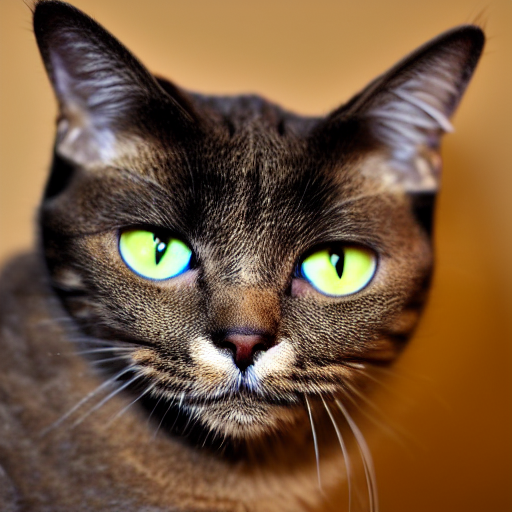

In [ ]:
generate_with_embs(modified_output_embeddings)

The token **2368** means a cat. 

Lets see how to access a token of a word. 

In [ ]:
# Getting the token for a given prompt 
prompt = "skunk"
print(f"tokenizer(prompt) {tokenizer(prompt)} \n")

print('token_emb_layer([token_id]) shape:', token_emb_layer(torch.tensor([8797], device=torch_device)).shape)


tokenizer(prompt) {'input_ids': [49406, 42194, 49407], 'attention_mask': [1, 1, 1]} 

token_emb_layer([token_id]) shape: torch.Size([1, 768])


0it [00:00, ?it/s]

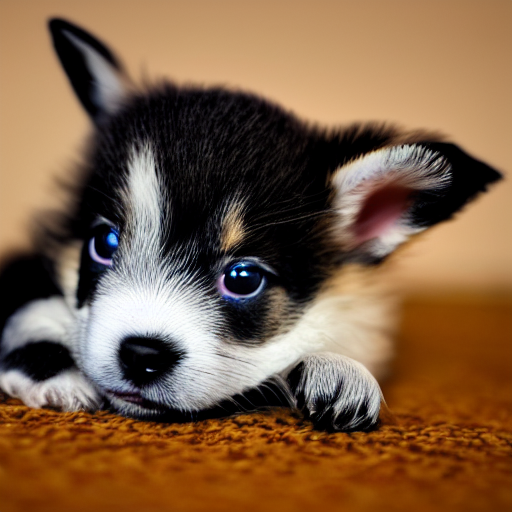

In [ ]:
# Making the puppy skunk hybrid (playing with the token)
prompt = "A picture of a puppy"

# Tokenize 
text_input = tokenizer(prompt , padding = "max_length" , max_length = tokenizer.model_max_length, 
                       truncation = True, return_tensors ="pt")
input_ids = text_input.input_ids.to(torch_device)

# Get token embeddings 
token_embeddings = token_emb_layer(input_ids)

# The new embedding, which is a mixture of puppy and a skunkk 
puppy_token_embedding = token_emb_layer(torch.tensor(6829 , device = torch_device))
skunk_token_embedding = token_emb_layer(torch.tensor(42194 , device = torch_device))

replacement_token_embedding = 0.5*puppy_token_embedding + 0.5*skunk_token_embedding

# Insert this into the token embeddings 
token_embeddings[0 , torch.where(input_ids[0] == 6829)] = replacement_token_embedding.to(torch_device)

# Combine with the positional embedding 
input_embeddings = token_embeddings + positional_embeddings

# Feed through to get final output 
modified_output_embeddings = get_output_embeds(input_embeddings)

# Output 
generate_with_embs(modified_output_embeddings)

## Textual Inversion 

 Here instead of a token we will insert a new learned token embedding for a specific concept. This is called texttual inversion, in which a few example images are used to create a new token embedding. 

 

In [ ]:
birb_embed = torch.load("learned_embeds.bin")
birb_embed.keys(), birb_embed['<birb-style>'].shape

(dict_keys(['<birb-style>']), torch.Size([768]))

We get a dictionary with a key (the special placeholder I used, ) and the corresponding token embedding. As in the previous example, let's replace the 'puppy' token embedding with this and see what happens:

0it [00:00, ?it/s]

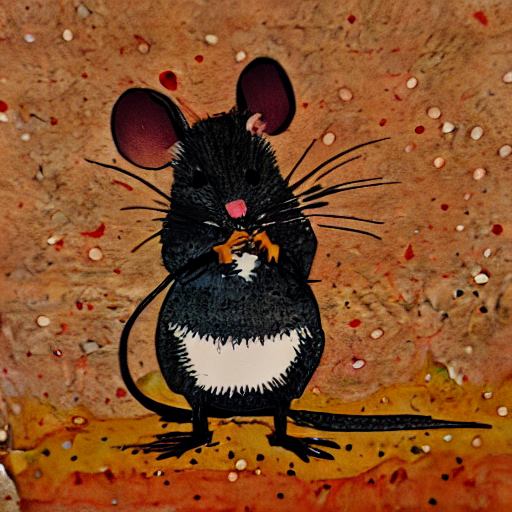

In [ ]:
prompt = 'A mouse in the style of puppy'

# Tokenize
text_input = tokenizer(prompt, padding="max_length", max_length=tokenizer.model_max_length, truncation=True, return_tensors="pt")
input_ids = text_input.input_ids.to(torch_device)

# Get token embeddings
token_embeddings = token_emb_layer(input_ids)

# The new embedding - our special birb word
replacement_token_embedding = birb_embed['<birb-style>'].to(torch_device)

# Insert this into the token embeddings
token_embeddings[0, torch.where(input_ids[0]==6829)] = replacement_token_embedding.to(torch_device)

# Combine with pos embs
input_embeddings = token_embeddings + positional_embeddings

#  Feed through to get final output embs
modified_output_embeddings = get_output_embeds(input_embeddings)

# And generate an image with this:
generate_with_embs(modified_output_embeddings)

The token for 'puppy' was replaced with one that captures a particular style of painting, but it could just as easily represent a specific object or class of objects.




## Messing with Embeddings 

Beside just replacing the token embedding of a single word, there are various tricks we can try. For example, what if we create a chimera by averagig the embeddigs of two different prompts? 



0it [00:00, ?it/s]

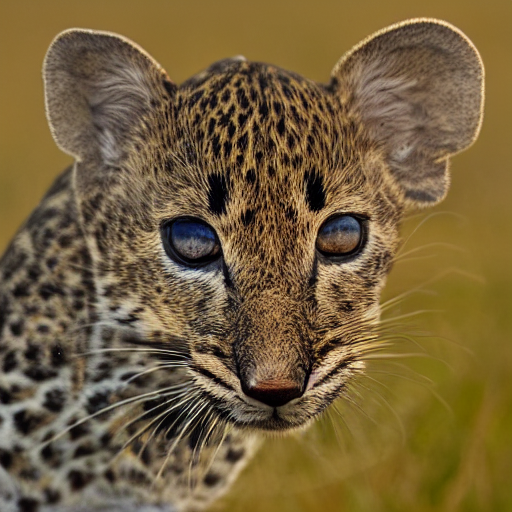

In [ ]:
# Embeddings of two prompts 
text_input_1 = tokenizer(["A mouse"] , padding = "max_length" , max_length = tokenizer.model_max_length , 
                          truncation = True, return_tensors = "pt")
text_input_2 = tokenizer(["A leoprad"] , padding = "max_length" , max_length = tokenizer.model_max_length , 
                          truncation = True, return_tensors = "pt")


# Creating the embeddings 
with torch.no_grad():
  text_embeddings1 = text_encoder(text_input_1.input_ids.to(torch_device))[0]
  text_embeddings2 = text_encoder(text_input_2.input_ids.to(torch_device))[0]


# Mix them together 
mix_factor = 0.35 # factor needed

mixed_embeddings = (text_embeddings1*mix_factor +
                   text_embeddings2*(1-mix_factor))


# Generate the output 

generate_with_embs(mixed_embeddings)

## The UNET and CFG 

Now its time we look into the actual diffusion model, this will be a typical Unet that tkaes in the noisy latents (X) and predicts the nosie. 

We use a conditional model that takes in the timestep (t) and also our text embedding (aka encoder_hidden_state) as conditioning. 

When we feed everything into ur model it will look like this, and it predicts the noise. 

`noise_pred = unet(latents, t, encoder_hiddem_state = text_embeddings)['sample']`

In [ ]:
# Preparing the noise scheduler
scheduler.set_timesteps(num_inference_steps)

# What is our timestep? 
t = scheduler.timesteps[0]
sigma = scheduler.sigmas[0]


# A noisy latent 
latents = torch.randn(
    (batch_size , unet.in_channels , height // 8,  width // 8) , 
    generator = generator
)
latents = latents.to(torch_device)
latents =  latents * scheduler.init_noise_sigma

# Configuring the text embedding 
text_input = tokenizer(['A macaw'], padding="max_length", max_length=tokenizer.model_max_length, truncation=True, return_tensors="pt")
with torch.no_grad():
    text_embeddings = text_encoder(text_input.input_ids.to(torch_device))[0]

# Run this through the unet and predict the noise residual 
with torch.no_grad():
  noise_pred = unet(latents , t , encoder_hidden_states = text_embeddings)['sample']

# Prediction should be of same size as the input
latents.shape , noise_pred.shape 

(torch.Size([1, 4, 64, 64]), torch.Size([1, 4, 64, 64]))

Given a set of noise latents, the model predicts the noise component. 

We can remove this noise from the noisy latents to see what the output image looks like `latents_x0 = latents - sigma * noise_pred`. 

And we can add most of the noise back to this predicted output to get the (slightly less noisy) input for the next difussion step. 

We can visualize this, 



In [ ]:
prompt = 'Oil painting of an otter in a top hat'
height = 512                      
width = 512                        
num_inference_steps = 50
guidance_scale = 8    
generator = torch.manual_seed(32)
batch_size = 1

# Make a folder to store results
!rm -rf steps/
!mkdir -p steps/

# Prep text 
text_input = tokenizer([prompt], padding="max_length", max_length=tokenizer.model_max_length, truncation=True, return_tensors="pt")
with torch.no_grad():
    text_embeddings = text_encoder(text_input.input_ids.to(torch_device))[0]
max_length = text_input.input_ids.shape[-1]
uncond_input = tokenizer(
    [""] * batch_size, padding="max_length", max_length=max_length, return_tensors="pt"
)
with torch.no_grad():
    uncond_embeddings = text_encoder(uncond_input.input_ids.to(torch_device))[0] 
text_embeddings = torch.cat([uncond_embeddings, text_embeddings])

# Prep Scheduler
scheduler.set_timesteps(num_inference_steps)

# Prep latents
latents = torch.randn(
  (batch_size, unet.in_channels, height // 8, width // 8),
  generator=generator,
)
latents = latents.to(torch_device)
latents = latents * scheduler.init_noise_sigma

# Loop
for i, t in tqdm(enumerate(scheduler.timesteps)):
    # expand the latents if we are doing classifier-free guidance to avoid doing two forward passes.
    latent_model_input = torch.cat([latents] * 2)
    sigma = scheduler.sigmas[i]
    latent_model_input = scheduler.scale_model_input(latent_model_input, t)

    # predict the noise residual
    with torch.no_grad():
        noise_pred = unet(latent_model_input, t, encoder_hidden_states=text_embeddings)["sample"]

    # perform guidance
    noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
    noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond)
    
    # Get the predicted x0:
    # latents_x0 = latents - sigma * noise_pred # Calculating ourselves
    latents_x0 = scheduler.step(noise_pred, t, latents).pred_original_sample # Using the scheduler (Diffusers 0.4 and above)

    # compute the previous noisy sample x_t -> x_t-1
    latents = scheduler.step(noise_pred, t, latents).prev_sample

    # To PIL Images
    im_t0 = latents_to_pil(latents_x0)[0]
    im_next = latents_to_pil(latents)[0]

    # Combine the two images and save for later viewing
    im = Image.new('RGB', (1024, 512))
    im.paste(im_next, (0, 0))
    im.paste(im_t0, (512, 0))
    im.save(f'steps/{i:04}.jpeg')

0it [00:00, ?it/s]

In [151]:
# Make and show the progress video (change width to 1024 for full res)
!ffmpeg -v 1 -y -f image2 -framerate 12 -i steps/%04d.jpeg -c:v libx264 -preset slow -qp 18 -pix_fmt yuv420p out.mp4
mp4 = open('out.mp4','rb').read()
data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
HTML("""
<video width=600 controls>
      <source src="%s" type="video/mp4">
</video>
""" % data_url)

THe version on the right shows the predicted **final output** (`x0`) and this is what is usually used in progress video. 

The version on the left is the next step, by watching the progress videos we'd think drastic changes are happening especially at early stages but sicne the changes made per step are relatively small the actual process is much more gradual. 